# Table of Contents
 <p><div class="lev1"><a href="#Task-1.-Compiling-Ebola-Data"><span class="toc-item-num">Task 1.&nbsp;&nbsp;</span>Compiling Ebola Data</a></div>
 <div class="lev1"><a href="#Task-2.-RNA-Sequences"><span class="toc-item-num">Task 2.&nbsp;&nbsp;</span>RNA Sequences</a></div>
 <div class="lev1"><a href="#Task-3.-Class-War-in-Titanic"><span class="toc-item-num">Task 3.&nbsp;&nbsp;</span>Class War in Titanic</a></div></p>

In [48]:
DATA_FOLDER = 'Data' # Use the data folder provided in Tutorial 02 - Intro to Pandas.
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

import glob
import os
import re
from datetime import datetime

sns.set_context('notebook')
pd.options.mode.chained_assignment = None  # default='warn', Mutes warnings when copying a slice from a DataFrame.import seaborn as sns

## Task 1. Compiling Ebola Data

The `DATA_FOLDER/ebola` folder contains summarized reports of Ebola cases from three countries (Guinea, Liberia and Sierra Leone) during the recent outbreak of the disease in West Africa. For each country, there are daily reports that contain various information about the outbreak in several cities in each country.

Use pandas to import these data files into a single `Dataframe`.
Using this `DataFrame`, calculate for *each country*, the *daily average per month* of *new cases* and *deaths*.
Make sure you handle all the different expressions for *new cases* and *deaths* that are used in the reports.

## Answer

We saw two possible ways to compute the mean:
1. Summing up all non-cumulative fields and dividing by the number of day in a month
(ex. for Guinea in August, I sum all values of the "New cases of confirmed" field and divide by 30)
2. Taking the last day of a month for a cumulative field, substracting the first day of the month and dividing by the number of day in a month.
(ex for Guinea in August, I take the value of the "Total new cases registered so far" at the 31st August, substract the the one of the 1st August and divide by 30)

We chose Approach 1 since it makes more use of our data compared to Approach 2 which uses just one field value.
We noticed the dataset is very dirty and inconsistent, most of the time, the cumulative data would jump up and down or be incomplete, we thus felt that using more data to compute the mean lets to better accuracy. 

We proceeded in the following way: 

1. We load all relevant columns from the .csv files in a single dataframe through a double nested for loop. 
   The newly-created dataframe has the following columns: 
  * country - the country associated with the row data. 
  * month - the month of year 2014 associated with the row data. In the .csv files, it was called 'Date' for Guinea and Liberia and 'date' for Sierra Leone.
  * variable - the description associated to the row data. In the .csv files, it was called 'Description' for Guinea and 'Variable' for Liberia and Sierra Leone.
  * value - the numerical value taken by the description. In the .csv files, it was called 'Totals' for Guinea and 'National' for Liberia and Sierra Leone.
2. We perform some simple data cleaning operations to handle both NaN and non-numerical values.
3. We rename the relevants fields to have something uniform, we chose the naming convention of the Guinea file.
4. We select only rows which are related to "new deaths" or "new cases" by filtering the dataframe.
5. We group the dataframe by country, then by month and finally by variable.
6. We use the aggregate operator sum in order to sum all the grouped value fields, and then divide by the average number of days in a month, i.e. 30. We choose to lose a bit of precision by not using the real number of days for each month because we believe the difference is negligible.

Also note that we chose a sum and not the mean function, because we assumed that since there is not a report for every single day of the month, the values for a specific day could be the values since the last report. E.g. there is a report on the 2nd and a report on the 5th, the number in the report of the 5th would account for everything that happend between the 2nd and the 5th.

We only kept a few columns of the original dataset, because what we really wanted was to be able to compare between the three countries what could be compared, i.e. what was present in all three dataset.

We noticed that for the end of december, the number of new cases were way too high and there were certainly a confusion between those fields and the cumulative fields, we thus set those to zero.

Since we chose approach one, we lose the new deaths values for Sierra Leone, since there is only cumulative deaths available. We chose not apply approach two on Sierra Leone only in order to have a consistency on how the data was treated.

In [40]:
base_folder = os.path.join(DATA_FOLDER, 'ebola')
datainfos = {'Guinea' : [os.path.join(base_folder, 'guinea_data'), [0,1,2]],
             'Liberia' : [os.path.join(base_folder, 'liberia_data'), [0,1,2]],
             'Sierra Leone' : [os.path.join(base_folder, 'sl_data'), [0,1,16]]}

frames = []

for country, datainfo in datainfos.items():
    datapath = datainfo[0]
    cols = datainfo[1]
    allFiles = glob.glob(datapath + "/*.csv")
    frame = pd.DataFrame()
    list = []
    for file in allFiles:
        df = pd.read_csv(file, usecols=cols, names=['month','variable','value'],
                         parse_dates=[0], header = None, skiprows = 1)
        #adding a new column to the dataframe in order to associate data to the respective country.
        df['country'] = country
        list.append(df)
        
    frame = pd.concat(list)
    frames.append(frame)

df = pd.concat(frames)

#data cleaning: substituting Nan with 0 
df.fillna(0, inplace=True)

#data cleaning: substituting non-numerical expressions with 0
df.replace(to_replace='.*%$', value='0', regex=True, inplace=True)
df.replace(to_replace='.*\..*$', value='0', regex=True, inplace=True)
df.replace(to_replace='.*\,.*', value='0', regex=True, inplace=True)

# modifying data type for the numerical value (String -> Int)
df.value = df.value.astype(int)

# We make sure that there is no improbable 'new' number, cf. remark above
df.value[df.value > 1000] = 0

# Renaming the variables for consistency
df.replace('New Case/s (Suspected)','New cases of suspects', inplace=True)
df.replace('New Case/s (Probable)','New cases of probables', inplace=True)
df.replace('New case/s (confirmed)','New cases of confirmed', inplace=True)
df.replace('new_suspected','New cases of suspects', inplace=True)
df.replace('new_probable','New cases of probables', inplace=True)
df.replace('new_confirmed','New cases of confirmed', inplace=True)
df.replace('New deaths registered today','New deaths registered', inplace=True)
df.replace('Newly reported deaths','New deaths registered', inplace=True)

relevant_variables = ['New cases of suspects', 'New cases of probables',\
                      'New cases of confirmed', 'New deaths registered']
df = df[df.variable.isin(relevant_variables)]
df.groupby([df.country, df.month.dt.month, df.variable])[['value']].sum()/30

value
country      month variable                         
Guinea       8     New cases of confirmed   2.066667
                   New cases of probables   0.266667
                   New cases of suspects    1.966667
                   New deaths registered    0.566667
             9     New cases of confirmed   6.933333
                   New cases of probables   0.633333
                   New cases of suspects    2.900000
                   New deaths registered    1.900000
             10    New cases of confirmed   0.200000
                   New cases of probables   0.000000
                   New cases of suspects    0.933333
                   New deaths registered    0.500000
Liberia      6     New cases of confirmed   0.500000
                   New cases of probables   0.266667
                   New cases of suspects    0.566667
                   New deaths registered    0.466667
             7     New cases of confirmed   0.666667
                   New cases of probables   1.366667
                   New cases of suspects    1.100000
                   New deaths registered    1.566667
             8     New cases of confirmed   1.633333
                   New cases of probables   5.933333
                   New cases of suspects    3.600000
                   New deaths registered    6.966667
             9     New cases of confirmed   4.933333
                   New cases of probables  23.466667
                   New cases of suspects   22.666667
                   New deaths registered   28.833333
             10    New cases of confirmed   1.133333
                   New cases of probables  14.800000
                   New cases of suspects   22.033333
                   New deaths registered   23.366667
             11    New cases of confirmed   1.300000
                   New cases of probables   3.500000
                   New cases of suspects    8.433333
                   New deaths registered    6.733333
             12    New cases of confirmed   0.333333
                   New cases of probables   0.633333
                   New cases of suspects    1.433333
                   New deaths registered    0.000000
Sierra Leone 8     New cases of confirmed  12.366667
                   New cases of probables   0.766667
                   New cases of suspects    3.633333
             9     New cases of confirmed  33.266667
                   New cases of probables   0.000000
                   New cases of suspects    6.066667
             10    New cases of confirmed  52.933333
                   New cases of probables   0.800000
                   New cases of suspects   12.466667
             11    New cases of confirmed  41.933333
                   New cases of probables   0.000000
                   New cases of suspects   10.733333
             12    New cases of confirmed   5.433333
                   New cases of probables   0.000000
                   New cases of suspects    1.400000

## Task 2. RNA Sequences

In the `DATA_FOLDER/microbiome` subdirectory, there are 9 spreadsheets of microbiome data that was acquired from high-throughput RNA sequencing procedures, along with a 10<sup>th</sup> file that describes the content of each. 

Use pandas to import the first 9 spreadsheets into a single `DataFrame`.
Then, add the metadata information from the 10<sup>th</sup> spreadsheet as columns in the combined `DataFrame`.
Make sure that the final `DataFrame` has a unique index and all the `NaN` values have been replaced by the tag `unknown`.

In [66]:
data_path_rna = os.path.join(DATA_FOLDER,'microbiome')

df_metadata = pd.read_excel(os.path.join(data_path_rna,'metadata.xls'),  sheetname='Sheet1')
df_metadata.set_index('BARCODE', inplace=True)

dfs = []
# We load each file according to the barcode
for barcode in df_metadata.index:
    file = os.path.join(data_path_rna, barcode + '.xls')
    
    df = pd.read_excel(file,  sheetname='Sheet 1', names=['Taxon', 'Count'])
    
    df['Group'] = df_metadata['GROUP'][barcode].lower()
    df['Sample'] = df_metadata['SAMPLE'][barcode]
    dfs.append(df)
    
df = pd.concat(dfs)
# We fill empty values with unknown
df.Sample[df.Sample.isnull()] = 'unknown'
# We create the unique MultiIndex
df = df.set_index(['Sample', 'Group', 'Taxon'])
print(df.index.is_unique)

df

True


Count
Sample  Group              Taxon                                                    
unknown extraction control Archaea "Crenarchaeota" Thermoprotei Desulfuroc...      2
                           Archaea "Crenarchaeota" Thermoprotei Sulfolobal...      3
                           Archaea "Crenarchaeota" Thermoprotei Thermoprot...      3
                           Archaea "Euryarchaeota" "Methanomicrobia" Metha...      7
                           Archaea "Euryarchaeota" "Methanomicrobia" Metha...      1
                           Archaea "Euryarchaeota" "Methanomicrobia" Metha...      1
                           Archaea "Euryarchaeota" Archaeoglobi Archaeoglo...      1
                           Archaea "Euryarchaeota" Archaeoglobi Archaeoglo...      1
                           Archaea "Euryarchaeota" Halobacteria Halobacter...      1
                           Archaea "Euryarchaeota" Halobacteria Halobacter...      4
                           Archaea "Euryarchaeota" Halobacteria Halobacter...      1
                           Archaea "Euryarchaeota" Halobacteria Halobacter...      2
                           Archaea "Euryarchaeota" Halobacteria Halobacter...      4
                           Archaea "Euryarchaeota" Methanococci Methanococ...      1
                           Archaea "Euryarchaeota" Methanopyri Methanopyra...     12
                           Archaea "Euryarchaeota" Thermoplasmata Thermopl...      2
                           Bacteria "Actinobacteria" Actinobacteria Actino...      2
                           Bacteria "Actinobacteria" Actinobacteria Actino...      1
                           Bacteria "Actinobacteria" Actinobacteria Actino...      1
                           Bacteria "Actinobacteria" Actinobacteria Actino...      1
                           Bacteria "Actinobacteria" Actinobacteria Actino...      2
                           Bacteria "Actinobacteria" Actinobacteria Actino...     53
                           Bacteria "Actinobacteria" Actinobacteria Actino...      1
                           Bacteria "Actinobacteria" Actinobacteria Actino...      2
                           Bacteria "Actinobacteria" Actinobacteria Actino...      3
                           Bacteria "Actinobacteria" Actinobacteria Actino...      1
                           Bacteria "Actinobacteria" Actinobacteria Actino...     99
                           Bacteria "Actinobacteria" Actinobacteria Actino...     17
                           Bacteria "Actinobacteria" Actinobacteria Actino...      2
                           Bacteria "Actinobacteria" Actinobacteria Actino...      2
...                                                                              ...
stool   control 2          Bacteria "Proteobacteria" Gammaproteobacteria O...     10
                           Bacteria "Proteobacteria" Gammaproteobacteria O...      1
                           Bacteria "Proteobacteria" Gammaproteobacteria O...      1
                           Bacteria "Proteobacteria" Gammaproteobacteria P...      1
                           Bacteria "Proteobacteria" Gammaproteobacteria P...     12
                           Bacteria "Proteobacteria" Gammaproteobacteria P...      4
                           Bacteria "Proteobacteria" Gammaproteobacteria P...    805
                           Bacteria "Proteobacteria" Gammaproteobacteria P...    862
                           Bacteria "Proteobacteria" Gammaproteobacteria P...     12
                           Bacteria "Proteobacteria" Gammaproteobacteria P...   3534
                           Bacteria "Proteobacteria" Gammaproteobacteria T...      4
                           Bacteria "Proteobacteria" Gammaproteobacteria T...      1
                           Bacteria "Proteobacteria" Gammaproteobacteria T...     25
                           Bacteria "Proteobacteria" Gammaproteobacteria T...      2
                           Bacteria "Proteobacteria" Gammaproteobacteria X...      3

We decided to completly ignore the Barcode column from the metadata file, since it was not needed for the index and it did not bring any useful information.

We can define a unique index by using the hierarchy Sample-Group-Taxon.

## Task 3. Class War in Titanic

Use pandas to import the data file `Data/titanic.xls`. It contains data on all the passengers that travelled on the Titanic.

In [67]:
from IPython.core.display import HTML
HTML(filename=DATA_FOLDER+'/titanic.html')

Name,Labels,Units,Levels,Storage,NAs
pclass,,,3,integer,0
survived,Survived,,,double,0
name,Name,,,character,0
sex,,,2,integer,0
age,Age,Year,,double,263
sibsp,Number of Siblings/Spouses Aboard,,,double,0
parch,Number of Parents/Children Aboard,,,double,0
ticket,Ticket Number,,,character,0
fare,Passenger Fare,British Pound (\243),,double,1
cabin,,,187,integer,0


For each of the following questions state clearly your assumptions and discuss your findings:
1. Describe the *type* and the *value range* of each attribute. Indicate and transform the attributes that can be `Categorical`. 
2. Plot histograms for the *travel class*, *embarkation port*, *sex* and *age* attributes. For the latter one, use *discrete decade intervals*. 
3. Calculate the proportion of passengers by *cabin floor*. Present your results in a *pie chart*.
4. For each *travel class*, calculate the proportion of the passengers that survived. Present your results in *pie charts*.
5. Calculate the proportion of the passengers that survived by *travel class* and *sex*. Present your results in *a single histogram*.
6. Create 2 equally populated *age categories* and calculate survival proportions by *age category*, *travel class* and *sex*. Present your results in a `DataFrame` with unique index.

## Answer
### Q1
#### Describe the *type* and the *value range* of each attribute. Indicate and transform the attributes that can be `Categorical`. 


- *pclass*: int ranging from 1 to 3 and can be transformed into a category
- *survived*: we transformed it from an int to a string which can be 'dead' or 'survived', it is a category
- *name*: string
- *sex*: string, female or male and can be transformed into a category
- *age*: float, ranging from 0.17 to 80.0, we kept ages < 1.0 assuming they were babies, e.g. the passenger aged 0.17 would be a 2 month old baby
- *sibsp*: int, ranging from 0 to 8
- *parch*: int, ranging from 0 to 9
- *ticket*: string, mainly with numbers, but also letters, we decided to keep it as strings since the letters could provide additional information
- *fare*: float, ranging from 0.0 to 512.33
- *cabin*: string
- *embarked*: char, C, Q or S, can be transformed into a category
- *boat*: string, mainly numbers, but also sometimes char, we kept it as string since a boat can be either named by a number either by a char.
- *body*: int, ranging from 1 to 328
- *home.dest*: string

In [44]:
df = pd.read_excel(os.path.join(DATA_FOLDER,'titanic.xls'))

df['pclass'] = df.pclass.astype('category')
df.pclass.cat.categories = [1, 2, 3]  

df['survived'] = df.survived.astype('category')
df.survived.cat.categories = ['dead', 'survived']

df['sex'] = df.sex.astype('category')

df['embarked'] = df.embarked.astype('category')
df.embarked.cat.categories = ['Cherbourg', 'Queenstown','Southampton']

### Q2
#### Plot histograms for the *travel class*, *embarkation port*, *sex* and *age* attributes. For the latter one, use *discrete decade intervals*. 

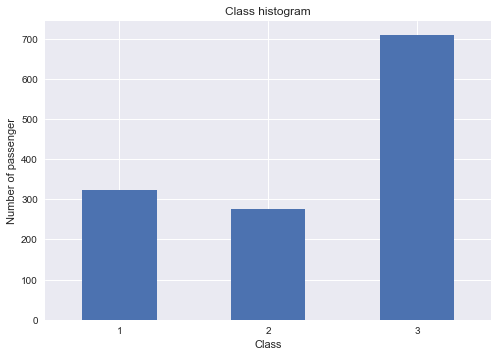

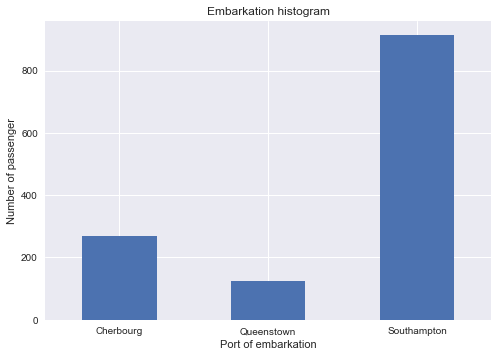

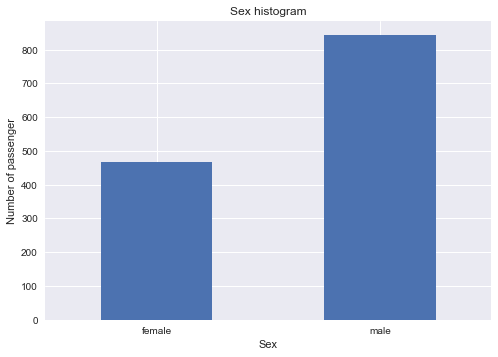

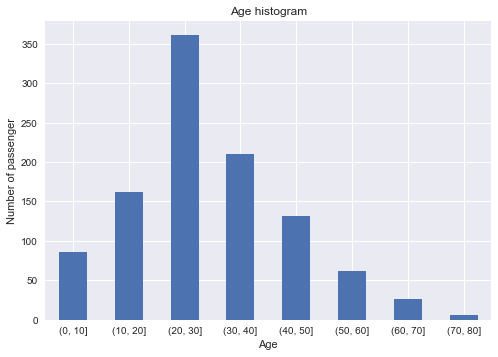

In [76]:
pclass_hist = df.pclass.value_counts().sort_index().plot(kind='bar',title='Class histogram')
pclass_hist.set_xlabel('Class')
pclass_hist.set_ylabel('Number of passenger')
plt.setp(plt.xticks()[1], rotation=0)
plt.show();

embarked_hist = df.embarked.value_counts().sort_index().plot(kind='bar',title='Embarkation histogram')
embarked_hist.set_xlabel('Port of embarkation')
embarked_hist.set_ylabel('Number of passenger')
plt.setp(plt.xticks()[1], rotation=0)
plt.show();

sex_hist = df.sex.value_counts().sort_index().plot(kind='bar',title='Sex histogram')
sex_hist.set_xlabel('Sex')
sex_hist.set_ylabel('Number of passenger')
plt.setp(plt.xticks()[1], rotation=0)
plt.show();

# We cut by age range
age_hist= pd.cut(df.age.dropna(), [0,10,20,30,40,50,60,70,80])\
    .value_counts().sort_index().plot(kind='bar',title='Age histogram')
age_hist.set_xlabel('Age')
age_hist.set_ylabel('Number of passenger')
plt.setp(plt.xticks()[1], rotation=0)
plt.show();

### Q3
#### Calculate the proportion of passengers by *cabin floor*. Present your results in a *pie chart*.

We chose to drop all numbers in the cabin and to only keep the last letter for the floor. We had to make this last decision because there were inconsistencies in the data, with cabin such as 'F G63'. We also assumed that if there were several cabin for a group of person, they were all on the same floor thus it does not change our result.

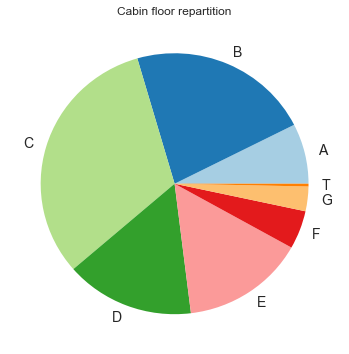

In [72]:
ax = df.cabin.dropna().str.replace('[0-9]*', '')\
    .replace({r'^.*([A-Z])$': r'\1'}, regex=True)\
    .value_counts().sort_index()\
    .plot.pie(title='Cabin floor repartition', fontsize=14, figsize=(6, 6), colors=sns.color_palette("Paired", 9));
ax.set_ylabel('')
plt.show();

### Q4
- For each *travel class*, calculate the proportion of the passengers that survived. Present your results in *pie charts*.


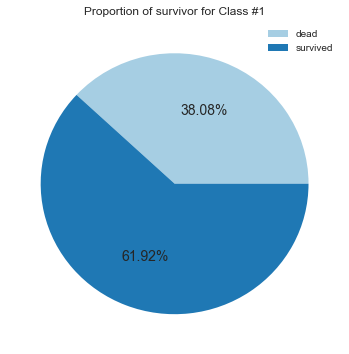

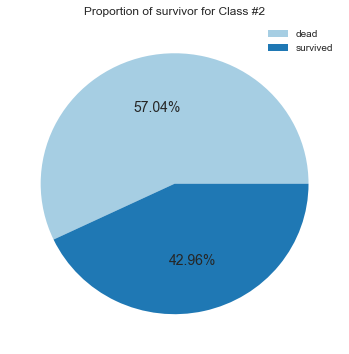

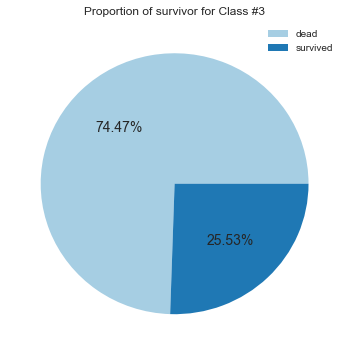

In [79]:
# For each travel class, we draw a pie
for title, group in df.groupby(df.pclass):
    ax = group.survived.value_counts().sort_index(ascending=True)\
        .plot(kind='pie',title='Proportion of survivor for Class #' + str(title),\
              labels=None,legend=True,autopct='%.2f%%',fontsize=14, figsize=(6, 6),\
              colors=sns.color_palette("Paired", 2))
    ax.set_ylabel('')
    plt.show();

### Q5
- Calculate the proportion of the passengers that survived by *travel class* and *sex*. Present your results in *a single histogram*.


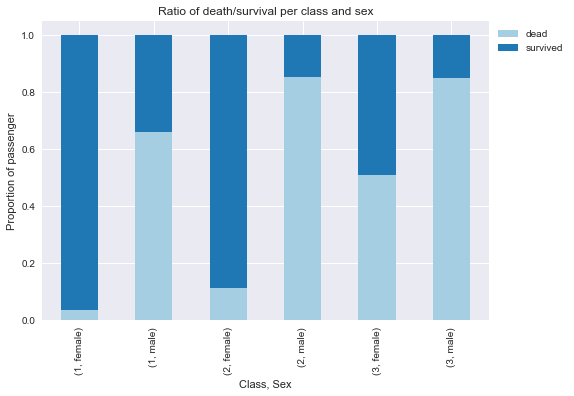

In [70]:
ax = df.groupby([df.pclass, df.sex]).survived.value_counts(normalize=True).unstack('survived')\
    .plot.bar(stacked=True, title='Ratio of death/survival per class and sex', color=sns.color_palette("Paired", 2));
ax.set_xlabel('Class, Sex')
ax.set_ylabel('Proportion of passenger')
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show();

### Q6
- Create 2 equally populated *age categories* and calculate survival proportions by *age category*, *travel class* and *sex*. Present your results in a `DataFrame` with unique index.


In [94]:
# We take only passengers with non NaN ages and sort them by age
df_age = df[df.age.notnull()].sort_values(by='age')
# We find the median
median =  df_age.age.median()
# We split the dataframe according to the median and assign categories
def split_age(age):
    if age <= median:
        return '0-' + str(median-1) + ' year old'
    else:
        return str(median) + '-' + str(max(df_split[1].age)) + ' year old'
    
df_age['age_category'] =  df_age.age.apply(split_age)
print(df_age.age_category.describe())
# We group by age category, class and sex, compute the percentage of survival,
# unstack and remove the percentage of deaths since we only care about survival date
df_age = df_age.groupby(['age_category','pclass','sex']).survived.value_counts(normalize=True).apply(lambda x: x*100)\
    .unstack().drop('dead', 1)
df_age.columns = ['Survival rate']
df_age

count                1046
unique                  2
top       0-27.0 year old
freq                  536
Name: age_category, dtype: object


Survival rate
age_category       pclass sex                  
0-27.0 year old    1      female      95.121951
                          male        53.125000
                   2      female      91.071429
                          male        21.621622
                   3      female      51.376147
                          male        18.303571
28.0-80.0 year old 1      female      96.739130
                          male        30.252101
                   2      female      87.234043
                          male         8.333333
                   3      female      37.209302
                          male        14.400000

The median did not give us a separation in half, but close enough (+26 people in a category, i.e. 2.6%).